In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns
import neuromodels as nm
import numpy as np
import pandas as pd
import seaborn as sns
import pylfi 

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
#plt.rc('text', usetex=True)

sns.set(context="paper", style='whitegrid', rc={"axes.facecolor": "0.98"})


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@c4a0daab5
 Built: Aug 13 2021 01:17:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Simulator model

In [2]:
class ConstantStimulus:
    def __init__(self, I_amp, t_stim_on, t_stim_off):
        self.I_amp = I_amp
        self.t_stim_on = t_stim_on
        self.t_stim_off = t_stim_off

    def __call__(self, t):
        return self.I_amp if self.t_stim_on <= t <= self.t_stim_off else 0
    
    
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]    
stimulus = ConstantStimulus(I_amp, t_stim_on, t_stim_off)

hh = nm.models.HodgkinHuxley(stimulus, T, dt)

### Statistics calculator

In [3]:
s_stats = ["spike_rate",
           "latency_to_first_spike",
           "average_AP_overshoot",
           "average_AHP_depth",
           "average_AP_width",
           "accommodation_index"]

sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on, 
                               t_stim_off=t_stim_off, 
                               stats=s_stats
                              )

### Observed data

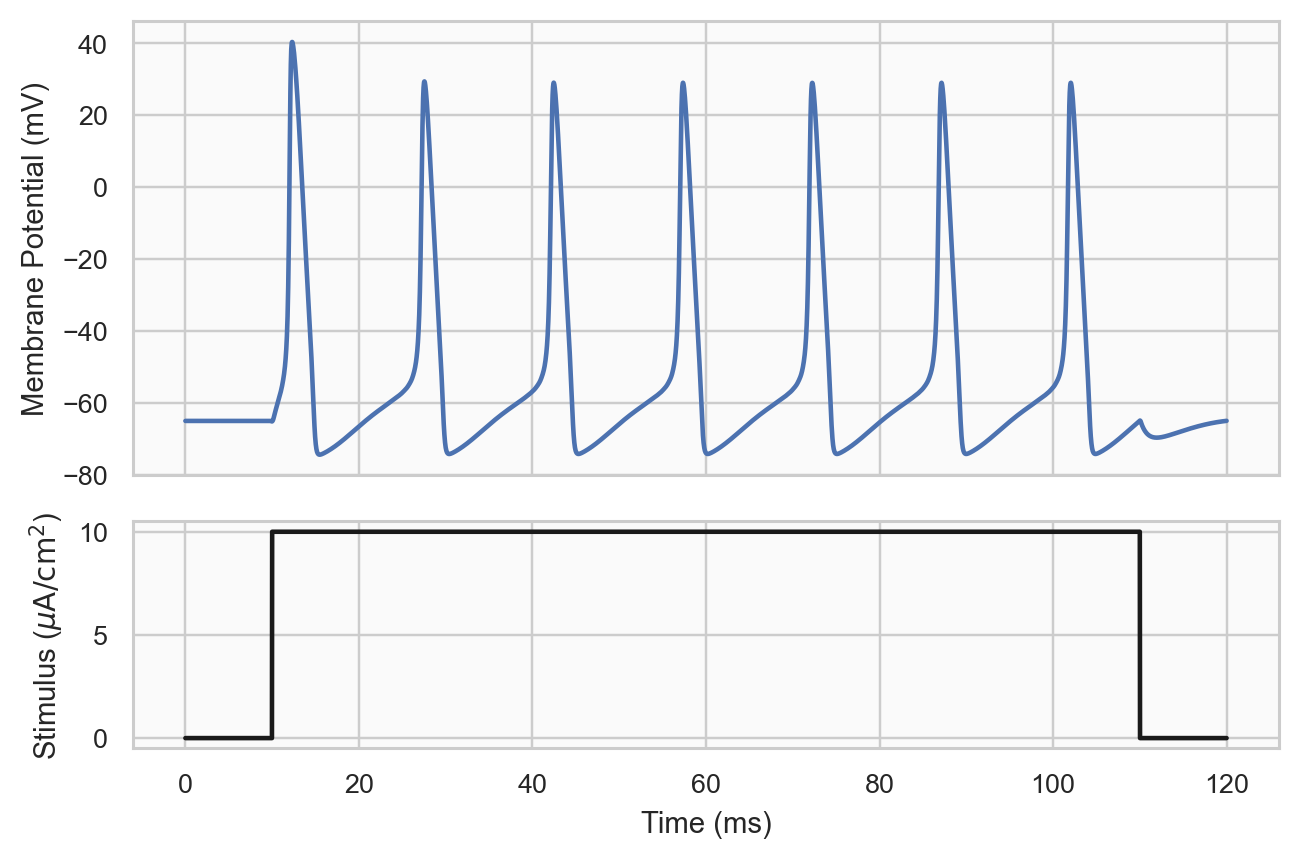

In [4]:
gbar_K_true = 36 
gbar_Na_true = 120 
true_parameter_values = [gbar_K_true, gbar_Na_true]

V, t = hh(gbar_K=gbar_K_true, gbar_Na=gbar_Na_true)
obs_data = (V, t)

# Plot observed data
hh.plot_voltage_trace(with_stim=True, figsize=(6, 4), dpi=110)
plt.show()

### Priors

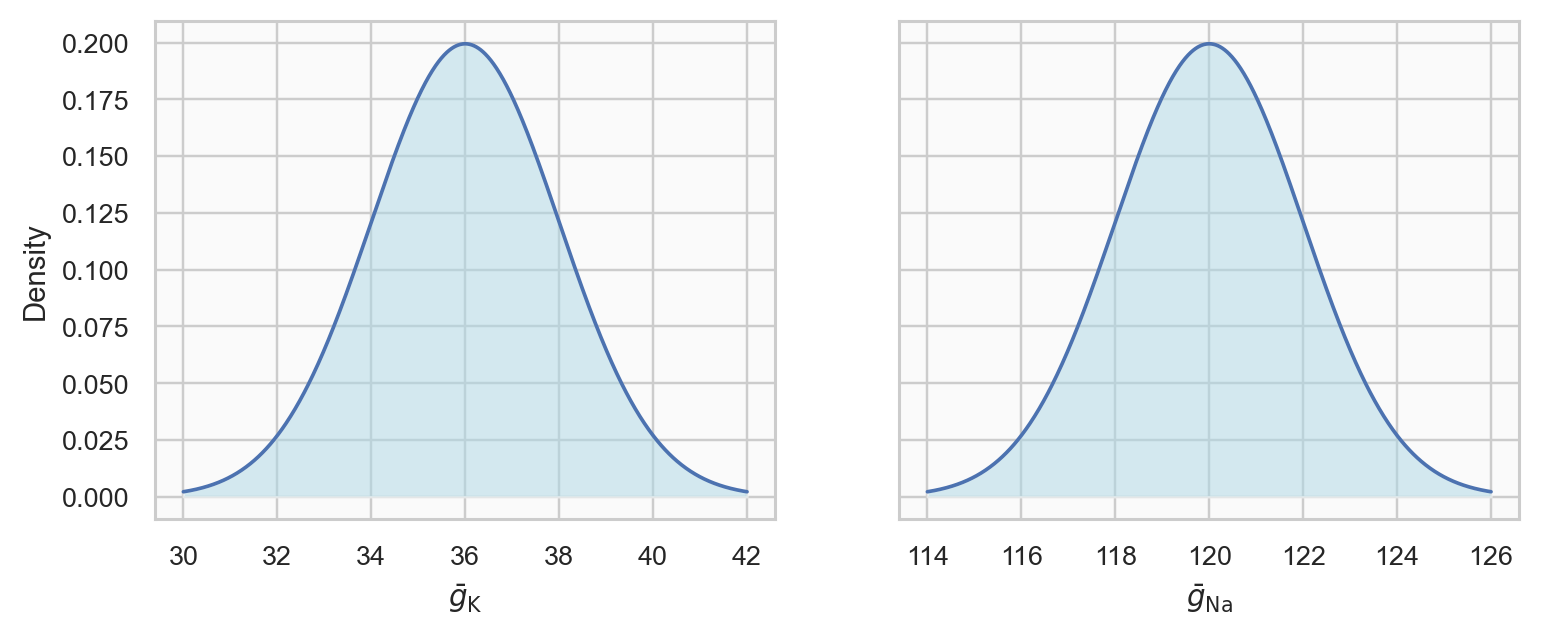

In [5]:
gbar_K = pylfi.Prior('norm', loc=36, scale=2, name='gbarK', tex=r"$\bar{g}_\mathrm{K}$")
gbar_Na = pylfi.Prior('norm', loc=120, scale=2, name='gbarNa', tex=r"$\bar{g}_\mathrm{Na}$")
priors = [gbar_K, gbar_Na]

# Plot priors
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), dpi=110, sharey=True)
x = np.linspace(30, 42, 1000)
gbar_K.plot_prior(x, ax=axes[0])

x = np.linspace(114, 126, 1000)
gbar_Na.plot_prior(x, ax=axes[1])
axes[1].set_ylabel("")

plt.show()

### Rejection ABC sampler

In [6]:
# initialize sampler
sampler = pylfi.RejABC(obs_data, 
                       hh,
                       sps, 
                       priors, 
                       distance_metric='l2',
                       seed=42
                      )

# inference config
n_samples = 100
quantile = 0.5
n_tune = 500

# run inference
journal = sampler.sample(n_samples,
                         quantile=quantile,
                         n_jobs=-1,
                         n_tune=n_tune,
                         log=False
                         )

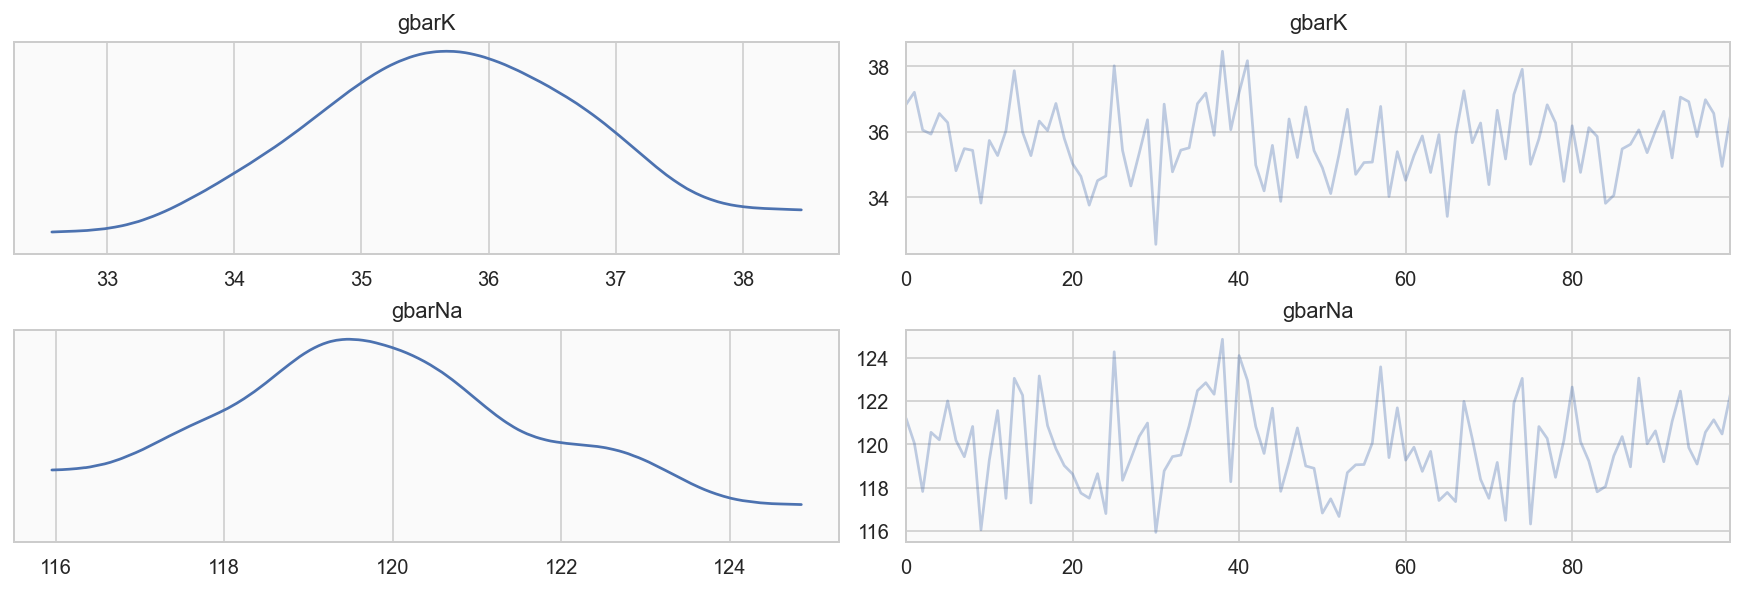

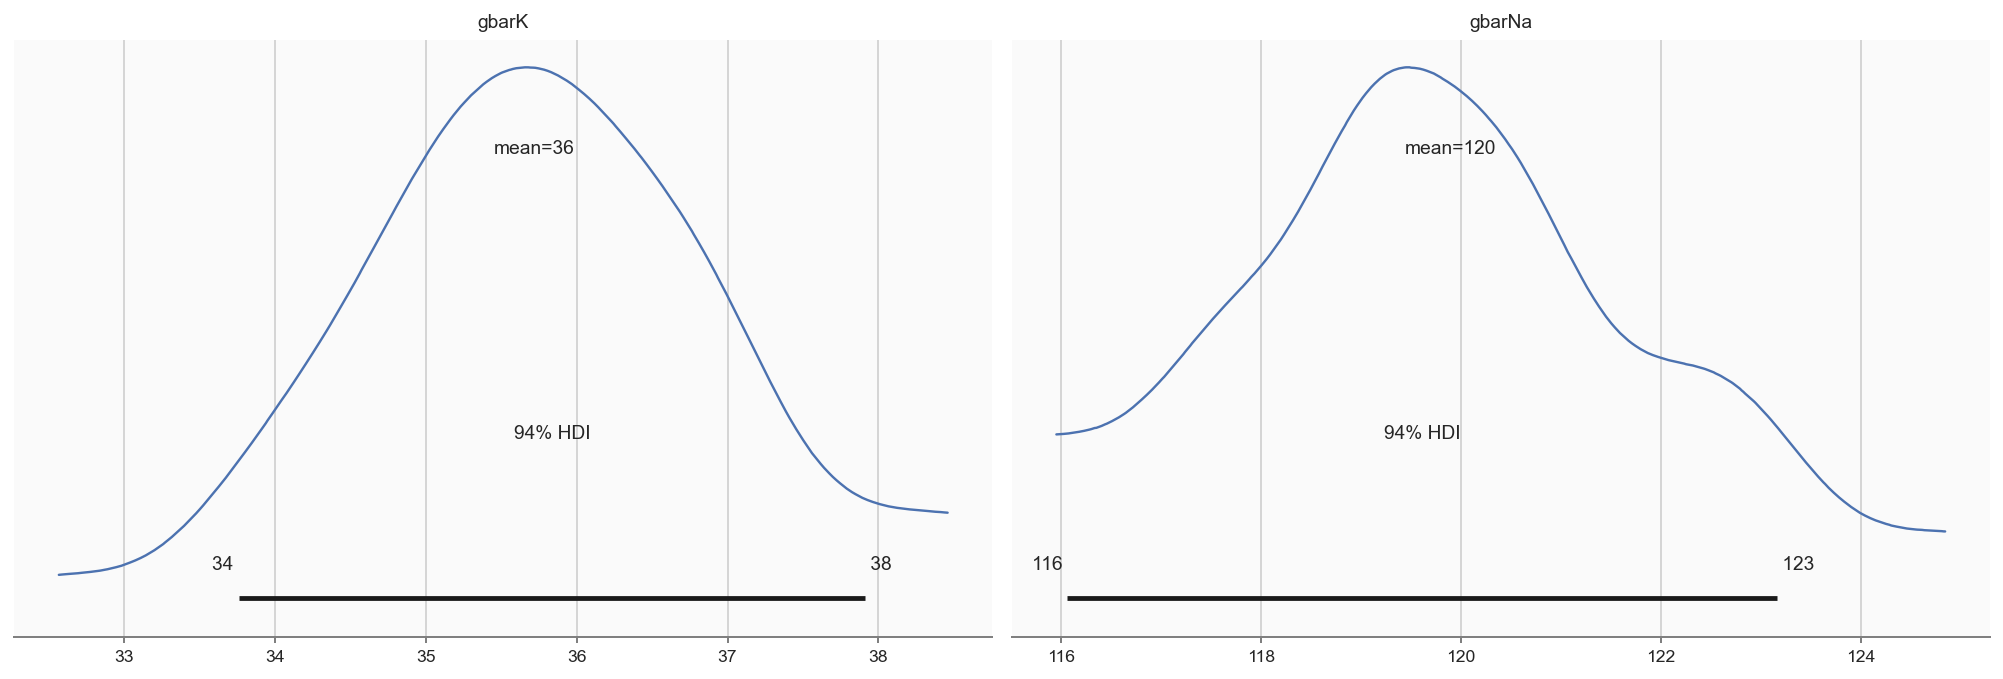

In [7]:
journal.plot_trace()
journal.plot_posterior()
plt.show()

In [8]:
df = journal.results_frame()
df

,gbarK,gbarNa,sum_stat1,sum_stat2,distance,epsilon
0,36.836660,121.211152,0.07,2.200,0.049859,0.16969
1,37.211152,120.057576,0.07,2.250,0.151251,0.16969
2,36.057576,117.831508,0.07,2.275,0.129543,0.16969
3,35.930553,120.560837,0.07,2.200,0.050487,0.16969
4,36.560837,120.214986,0.07,2.225,0.064685,0.16969
...,...,...,...,...,...,...
95,35.855999,119.094935,0.07,2.225,0.051498,0.16969
96,36.983688,120.565469,0.07,2.275,0.089953,0.16969
97,36.565469,121.139513,0.07,2.225,0.018718,0.16969
98,34.944918,120.483714,0.07,2.225,0.135081,0.16969


In [9]:
s_obs = [0.0700, 2.3000, 30.7316, -63.6200, 2.0501, 0.0000]
s_sim = [0.0800, 2.1750, 31.5594, -64.6691, 2.2020, -0.0001]
sd = [0.005642455773231649, 0.05382597753759344, 1.7046253854703737,
      0.6874275920415303, 0.12949201564346335, 0.0006322033040264965]
mad = [0.005133541449878599, 0.04342120476355643, 1.324492157592733,
       0.5771365941252231, 0.10528066752986871, 0.00029063943717396053]

scales = sd
weights = [0.23514191, 0.09056595, 0.25585964,
           0.19059709, 0.1906825, 0.03715291]

def distance(s_sim, s_obs, weight=1, scale=1):
    if isinstance(s_sim, (int, float)):
        s_sim = [s_sim]
    if isinstance(s_obs, (int, float)):
        s_obs = [s_obs]

    s_sim = np.asarray(s_sim)
    s_obs = np.asarray(s_obs)

    '''
    if s_sim.ndim == 1:
        s_sim = s_sim.reshape(-1, 1)

    if s_obs.ndim == 1:
        s_obs = s_obs.reshape(-1, 1)
    '''

    q = weight * (s_sim - s_obs) / scale
    # print(q)

    dist = np.linalg.norm(q.reshape(-1, 1), ord=2, axis=1)
    print(dist)
    print(np.mean(dist))
    dist = np.sqrt(q * q).sum()
    print(dist)
    dist = np.sqrt(q**2).sum(-1)
    print(dist)
    return dist

In [22]:
def distance1(s_sim, s_obs, weight=1, scale=1):
    if isinstance(s_sim, (int, float)):
        s_sim = [s_sim]
    if isinstance(s_obs, (int, float)):
        s_obs = [s_obs]

    s_sim = np.asarray(s_sim)
    s_obs = np.asarray(s_obs)

    q = weight * (s_sim - s_obs) / scale
    dist = np.linalg.norm(q, ord=2)
    return dist

In [23]:
def distance2(s_sim, s_obs, weight=1, scale=1):
    if isinstance(s_sim, (int, float)):
        s_sim = [s_sim]
    if isinstance(s_obs, (int, float)):
        s_obs = [s_obs]

    s_sim = np.asarray(s_sim)
    s_obs = np.asarray(s_obs)

    q = weight * (s_sim - s_obs) / scale
    dist = np.sqrt(np.sum(q * q))
    return dist

In [24]:
%%timeit
dist = distance1(s_sim, s_obs, weight=weights, scale=scales)

10.2 µs ± 487 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
%%timeit
dist = distance2(s_sim, s_obs, weight=weights, scale=scales)

11.6 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
